# Install and import

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

Cloning into 'AdversarialRegularization'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 83 (delta 36), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [3]:
from AdversarialRegularization.utils import *

# Loading Models

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

We want to collect good filters. For that purpose, we load models that have been trained on a large dataset. These models differ only in initial weight initialization.

In [5]:
model_dir = 'AdversarialRegularization/models/'
model_lst = []

for model_name in os.listdir('AdversarialRegularization/models/'):
    model_path = os.path.join(model_dir, model_name)
    model = CNN(num_classes=100)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_lst.append(model)

In [6]:
model_lst[0]

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [7]:
print('Number of models:', len(model_lst))

Number of models: 5


# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [8]:
# A freezed dataset of filters that does not stores gradients.

class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [9]:
# A differentiable version of this dataset. We use it to construct dataset of filters to train generative part of classifier.

class ParameterFilterDataset(Dataset):
    def __init__(self, layer):
        self.kernels = layer.weight
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [10]:
model_lst[0].features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [11]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

In [12]:
filter_bs = 128

filters_data = []
filters_loader = []

# Create datasets for 7x7, 5x5, 5x5 kernels from corresponding convolution layers 
filters_data.append(FilterDataset([model.features[0] for model in model_lst]))
filters_data.append(FilterDataset([model_lst[0].features[3]]))
filters_data.append(FilterDataset([model_lst[0].features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data)):
    filters_loader.append(DataLoader(filters_data[i], batch_size=filter_bs, shuffle=True))

In [13]:
for i in range(len(filters_loader)):
    print(f'Filter Dataset {i} size: {len(filters_loader[i].dataset)}')

Filter Dataset 0 size: 960
Filter Dataset 1 size: 8192
Filter Dataset 2 size: 16384


Now, we can iterate over filters dataset.

In [14]:
for batch in filters_loader[0]:
    print(batch)
    break

tensor([[[[-0.0879, -0.0739, -0.0795,  ...,  0.0731,  0.0798,  0.0049],
          [-0.0744,  0.0545,  0.0253,  ...,  0.2629,  0.1220,  0.0514],
          [ 0.0422,  0.2136,  0.3394,  ...,  0.2163, -0.0506, -0.2390],
          ...,
          [ 0.1515,  0.1743, -0.0196,  ..., -0.3626, -0.2900, -0.0979],
          [ 0.0293,  0.0629, -0.1564,  ..., -0.2374, -0.1608,  0.0408],
          [-0.0488, -0.0688, -0.1477,  ..., -0.0452,  0.0429,  0.2405]]],


        [[[ 0.0025,  0.0336, -0.0175,  ...,  0.1137,  0.1465,  0.1374],
          [-0.0019,  0.0114,  0.0537,  ...,  0.1063,  0.1444,  0.0270],
          [ 0.0727,  0.0320,  0.0763,  ...,  0.1393,  0.1422,  0.0022],
          ...,
          [ 0.0276, -0.0455,  0.0459,  ..., -0.0118, -0.0496, -0.1666],
          [ 0.0085, -0.0285, -0.0370,  ..., -0.1572, -0.1378, -0.1835],
          [-0.0284, -0.1524, -0.2105,  ..., -0.2875, -0.1830, -0.2405]]],


        [[[ 0.0039, -0.0441, -0.0199,  ...,  0.0432, -0.0778, -0.0106],
          [ 0.0023,  0.041

We can also visualize kernels to check if our dataset contains patterns.

In [15]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='coolwarm')

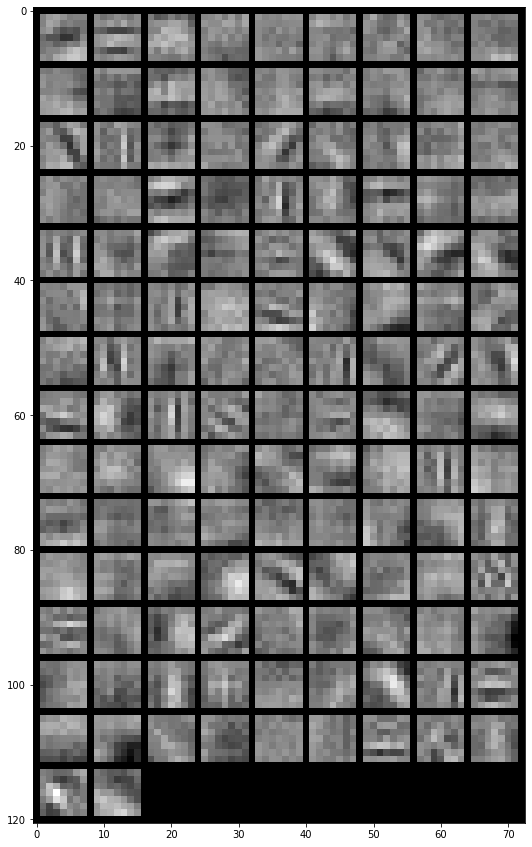

In [16]:
plot_kernels(filters_loader[0], nrow=9)

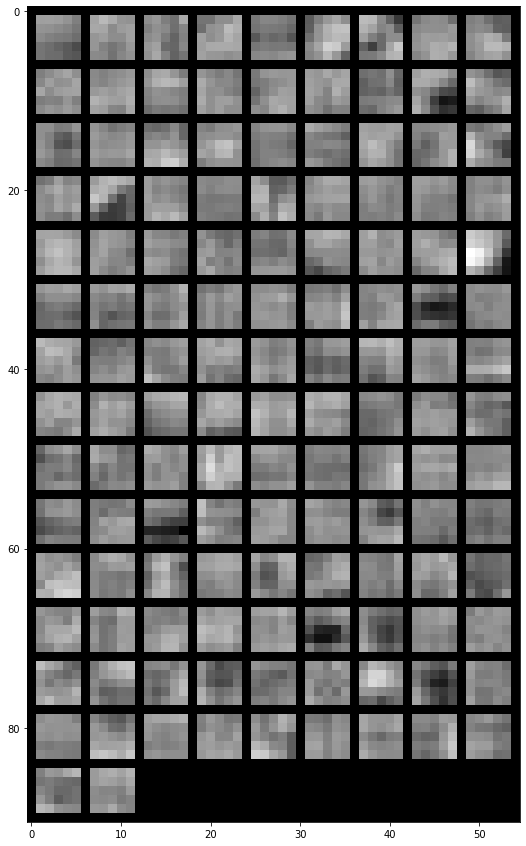

In [17]:
plot_kernels(filters_loader[1], nrow=9)

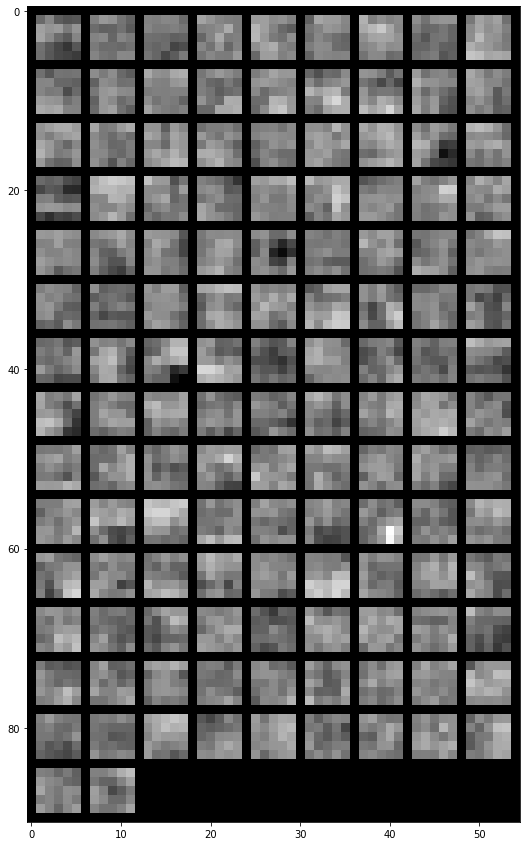

In [18]:
plot_kernels(filters_loader[2], nrow=9)

# Prepare data

Now we load CIFAR10 and take a small subset of it. We restrict this subset to have equal number of images per class to make dataset balanced.

In [19]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5)])

train_set = torchvision.datasets.CIFAR10('./cifar10', train=True, download=True,
                                         transform=train_transform)

test_set = torchvision.datasets.CIFAR10('./cifar10', train=False, download=True,
                                        transform=test_transform)

print('Train size', len(train_set))
print('Test size', len(test_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Train size 50000
Test size 10000


In [20]:
train_size = 100 / len(train_set)

In [21]:
train_idx, _ = train_test_split(np.arange(len(train_set)),
                                train_size=train_size,
                                shuffle=True,
                                random_state=42,
                                stratify=train_set.targets)

Let's make sure that the obtained indices are indeed stratified by classes.

In [22]:
pd.DataFrame(train_set.targets).rename(columns={0: 'class'}).iloc[train_idx].groupby('class').size()

class
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
9    10
dtype: int64

In [23]:
train_set = Subset(train_set, train_idx)

In [24]:
img_bs = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=img_bs, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=img_bs, shuffle=False, num_workers=2)

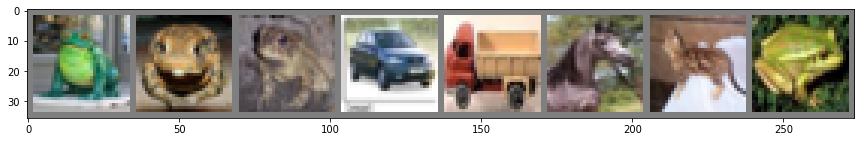

In [25]:
plot_random_images(train_loader)

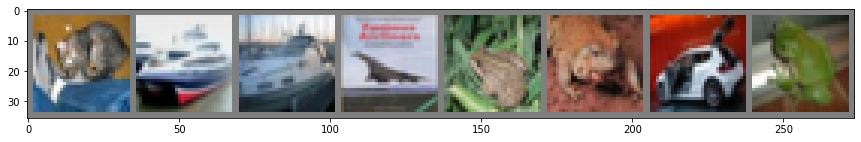

In [26]:
plot_random_images(test_loader)

# Training with adversarial regularization

Here, we train a model on small dataset with adversarial regularization. We apply regularization only on filters from the first convolutional layer (7x7). Adversarial regularization coefficient is fixed as 1.

In [28]:
RANDOM_SEED = 0

set_random_seeds(seed_value=RANDOM_SEED, device=device)

clf = CNN(num_classes=10).to(device)
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf.parameters()]))

Number of weights: 922442


In [29]:
# Contain classifier's weights into dataset abstraction to yield stochastic mini-batches with gradients

diff_fake_filters = ParameterFilterDataset(clf.features[0])
diff_fake_loader = DataLoader(diff_fake_filters, batch_size=filter_bs, shuffle=True)

In [30]:
# custom weights initialization called on netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [33]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of weights:', np.sum([np.prod(p.shape) for p in netD.parameters()]))

Number of weights: 74817


In [34]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): AdaptiveAvgPool2d(output_size=1)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [35]:
# Initialize criterions for classifier and discriminator
criterion_clf = nn.CrossEntropyLoss()
criterion_D = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both classifier and discriminator
opt_clf = torch.optim.Adam(clf.parameters(), lr=2e-4, weight_decay=1e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(netD.parameters(), lr=2e-4, weight_decay=1e-4, betas=(0.5, 0.999))

# Set adversarial coefficient to scale generative and discriminative losses
adversarial_coef = 1.

In [36]:
def iter_discriminator(real_loader, fake_batch, netD, criterion_D, opt_D, adversarial_coef):
    netD.train()
    netD.zero_grad()
    #############################
    ## Train with all-real batch
    # Format batch
    real_batch = next(iter(real_loader)).to(device)
    b_size = real_batch.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(real_batch).view(-1)
    # Calculate loss on all-real batch
    errD_real = adversarial_coef * criterion_D(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_real = output.mean().item()

    #############################
    ## Train with all-fake batch
    # Format batch
    fake_batch = fake_batch.detach().to(device)
    b_size = fake_batch.size(0)
    label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
    # Classify all fake batch with D
    output = netD(fake_batch).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = adversarial_coef * criterion_D(output, label)
    # Calculate the gradients for this batch, accumulated with previous gradients
    errD_fake.backward()
    D_fake = output.mean().item()
    # Compute error of D as sum over the fake and real batches
    errD = errD_real + errD_fake
    # Update D
    opt_D.step()

    return errD.item(), D_real, D_fake

In [37]:
def epoch_train(img_loader, fake_loader, clf, netD, criterion_clf, criterion_G, opt_clf, adversarial_coef):
    G_losses = []
    D_losses = []
    prob_cond_real = []
    prob_cond_fake = []

    #############################
    ## Update classifier
    clf.train()
    for data, target in img_loader:
        data = data.to(device)
        #############################
        ## Classifier loss
        target = target.to(device)
        output_clf = clf(data)
        loss = criterion_clf(output_clf, target)

        #############################
        ## Generator loss
        # Format batch
        fake_batch = next(iter(fake_loader))
        b_size = fake_batch.size(0)
        # Fake labels are real for generator cost
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass fake batch through D
        output_D = netD(fake_batch).view(-1)
        # Calculate generative loss based on D's output
        errG = criterion_G(output_D, label)
        
        #############################
        # Accumulate losses
        loss += adversarial_coef * errG
        G_losses.append(errG.item())
        # Update gradients
        opt_clf.zero_grad()
        loss.backward()
        opt_clf.step()

        #############################
        ## Update discriminators
        errD, D_real, D_fake = iter_discriminator(real_loader, fake_batch, netD, criterion_D, opt_D, adversarial_coef)
        D_losses.append(errD)
        prob_cond_real.append(D_real)
        prob_cond_fake.append(D_fake)
    
    #############################
    ## Evaluation
    clf.eval()
    train_loss = 0
    with torch.no_grad():
        for data, target in img_loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            train_loss += criterion_clf(output, target).item()
    train_acc = get_accuracy(clf, img_loader, device)
    train_loss /= len(img_loader)

    #############################
    ## Logging GAN statistics
    gan_stats = {}
    gan_stats['G_losses'] = G_losses
    gan_stats['D_losses'] = D_losses
    gan_stats['D_real'] = prob_cond_real
    gan_stats['D_fake'] = prob_cond_fake

    return train_loss, train_acc, gan_stats

In [38]:
def epoch_test(img_loader, clf, criterion_clf):
    clf.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in img_loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            test_loss += criterion_clf(output, target).item()
    test_acc = get_accuracy(clf, img_loader, device)
    test_loss /= len(img_loader.dataset)
    return test_loss, test_acc

In [39]:
n_epochs = 1000

D_losses = []
G_losses = []
prob_cond_real = []
prob_cond_fake = []
test_scores = []

real_loader = filters_loader[0]

print("Starting Training Loop...")
for epoch in range(n_epochs):
    train_loss, train_acc, gan_stats = epoch_train(train_loader, diff_fake_loader, clf, netD, criterion_clf, criterion_D, opt_clf, adversarial_coef)

    errG = gan_stats['G_losses']
    errD = gan_stats['D_losses']
    D_real = gan_stats['D_real']
    D_fake = gan_stats['D_fake']

    if epoch % 10 == 9:
        test_loss, test_acc = epoch_test(test_loader, clf, criterion_clf)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')
        print(f'Discriminator loss: {np.mean(errD)}')
        print(f'Generator loss: {np.mean(errG)}')
        test_scores.append(test_acc)

    G_losses += errG
    D_losses += errD
    prob_cond_real += D_real
    prob_cond_fake += D_fake

Starting Training Loop...
[Epoch 10] train loss: 0.201; train acc: 1.00; test loss: 0.132; test acc: 0.22
Discriminator loss: 1.2547620705195837
Generator loss: 0.7841105546270098
[Epoch 20] train loss: 0.059; train acc: 1.00; test loss: 0.133; test acc: 0.23
Discriminator loss: 1.1331230061394828
Generator loss: 0.8482219065938678
[Epoch 30] train loss: 0.030; train acc: 1.00; test loss: 0.134; test acc: 0.22
Discriminator loss: 1.0057389310428075
Generator loss: 0.9366838761738369
[Epoch 40] train loss: 0.025; train acc: 1.00; test loss: 0.136; test acc: 0.21
Discriminator loss: 0.8704486063548497
Generator loss: 1.0417684316635132
[Epoch 50] train loss: 0.013; train acc: 1.00; test loss: 0.136; test acc: 0.21
Discriminator loss: 0.7651089429855347
Generator loss: 1.148493460246495
[Epoch 60] train loss: 0.018; train acc: 1.00; test loss: 0.142; test acc: 0.20
Discriminator loss: 0.6707476547786168
Generator loss: 1.262353505407061
[Epoch 70] train loss: 0.018; train acc: 1.00; test 

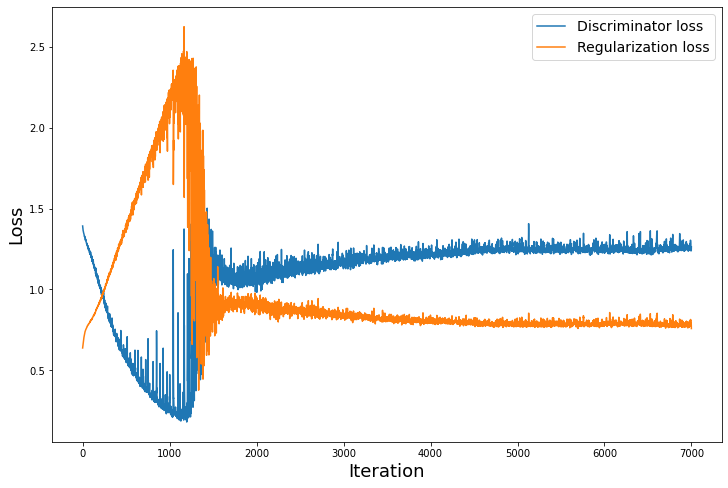

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(D_losses, label='Discriminator loss')
plt.plot(G_losses, label='Regularization loss')
plt.xlabel('Iteration', size=18)
plt.ylabel('Loss', size=18)
plt.legend(fontsize=14)
plt.show()

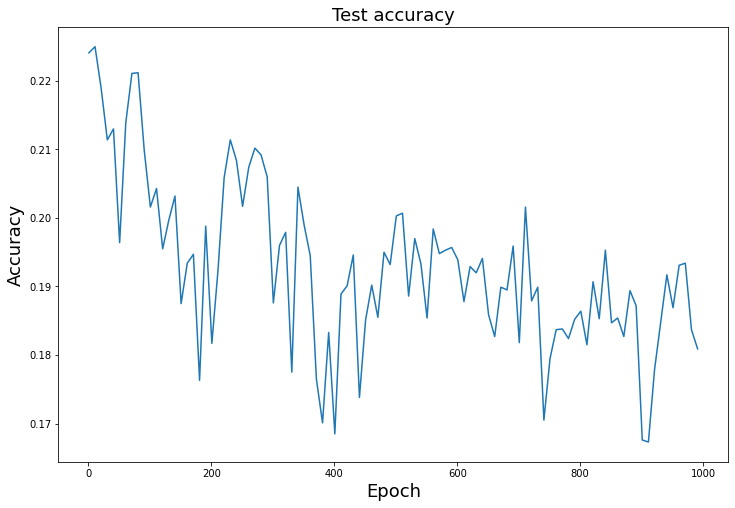

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 1001, 10), test_scores)
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.title('Test accuracy', size=18)
plt.show()

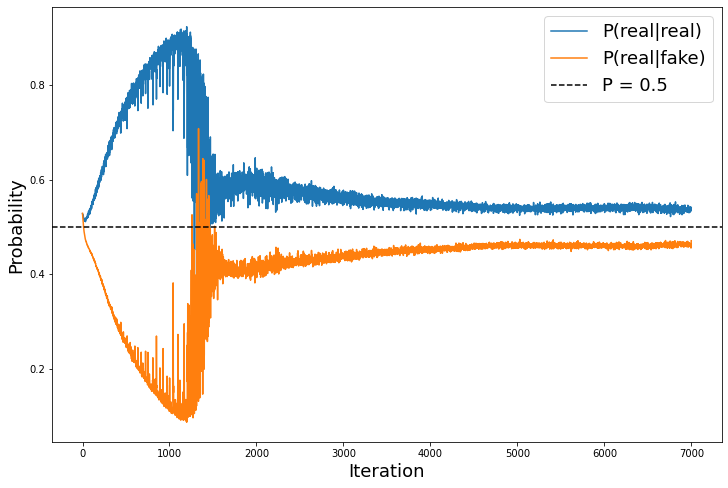

In [51]:
plt.figure(figsize=(12,8))
plt.plot(prob_cond_real, label='P(real|real)')
plt.plot(prob_cond_fake, label='P(real|fake)')
plt.axhline(0.5, c='black', linestyle='--', label='P = 0.5')
plt.xlabel('Iteration', size=18)
plt.ylabel('Probability', size=18)
plt.legend(fontsize=18)
plt.show()

In [59]:
filters_data = []
filters_loader = []

filters_data.append(FilterDataset([clf.to('cpu').features[0]]))
filters_data.append(FilterDataset([clf.to('cpu').features[3]]))
filters_data.append(FilterDataset([clf.to('cpu').features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data)):
    filters_loader.append(DataLoader(filters_data[i], batch_size=filter_bs, shuffle=True))

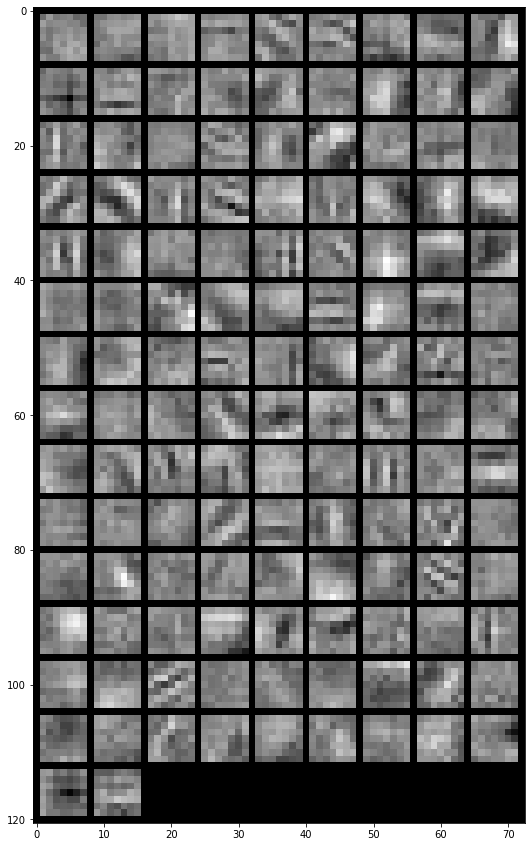

In [60]:
plot_kernels(filters_loader[0], nrow=9)

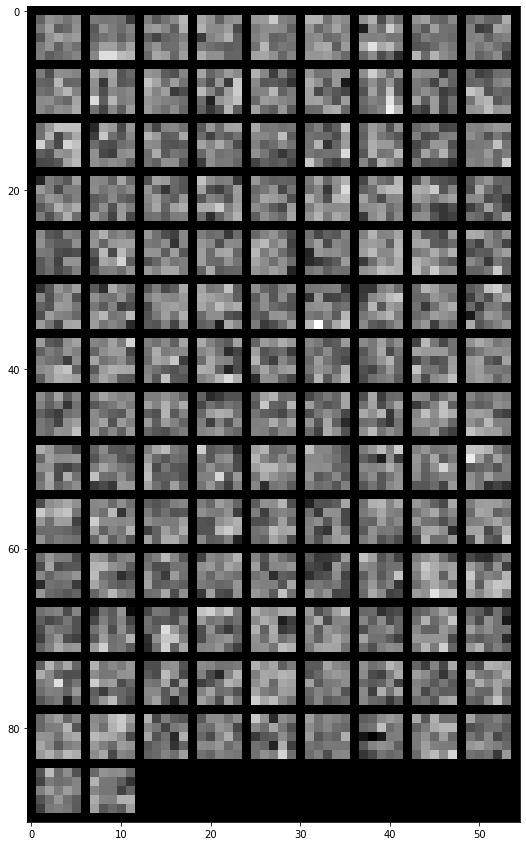

In [61]:
plot_kernels(filters_loader[1], nrow=9)

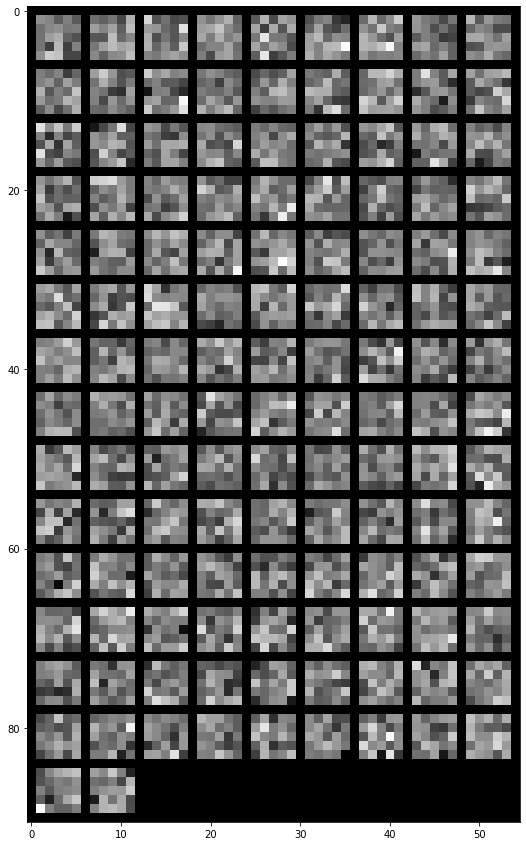

In [62]:
plot_kernels(filters_loader[2], nrow=9)